## Generative AI with Langchain - Summarize an entire book (Advanced)


* Book may have large numbers of tokens which may increase the overall cost of LLM model.

* We will use some advance technique to reduce the cost of using LLM by clustering the embeddings

* I am using Google GenAI Gemini Pro LLM using LangChain and the same task can be achieved using OpenAI model

In [1]:
import warnings
warnings.filterwarnings('ignore')

import google.generativeai as genai
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate

from langchain.document_loaders import PyPDFLoader
from langchain.schema import Document

import pinecone
from langchain.vectorstores import Pinecone
from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain.chains.summarize import load_summarize_chain
from sklearn.cluster import KMeans

import getpass
import pandas as pd
import numpy as np
import os, sys

#from dotenv import load_dotenv
#load_dotenv()

#from langchain.chat_models import ChatOpenAI
#from langchain.embeddings import OpenAIEmbeddings

In [2]:
os.environ["GOOGLE_API_KEY"] = getpass.getpass(prompt="Enter your GenAI API key: ")

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])
llm = genai.GenerativeModel('gemini-pro')

Enter your GenAI API key: ········


In [3]:
loader = PyPDFLoader("Sample_Datasets\power-of-ur-subconscious-mind.pdf")
pages = loader.load()

# Initial pages have only index and tables, so slicing the this as per the PDF
pages = pages[15:170]

# Combine the pages and replace the tabs with spaces
text = ""

for page in pages:
    text += page.page_content
    
text = text.replace('\t', ' ')

In [4]:
num_tokens = llm.count_tokens(text)

print (f"This book has {num_tokens} tokens in it")

This book has total_tokens: 89733
 tokens in it


That's approx 90K tokens, even [GPT 32K](https://help.openai.com/en/articles/7127966-what-is-the-difference-between-the-gpt-4-models) wouldn't be able to handle that in one go. At [0.03 per 1K prompt tokens](https://help.openai.com/en/articles/7127956-how-much-does-gpt-4-cost), this would cost us $2.70 just for the prompt alone.

So how do we do this without going through all the tokens? Pick random chunks? Pick equally spaced chunks?


**Goal:** Chunk the book then get embeddings of the chunks. Pick a subset of chunks which represent a wholistic but diverse view of the book. Or another way, is there a way to pick the top 10 passages that describe the book the best?

Once we have our chunks that represent the book then we can summarize those chunks and hopefully get a pretty good summary.

**The Steps we are following here:**
1. Load the book into a single text file
2. Split the text into large chunks
3. Embed the chunks to get vectors
4. Cluster the vectors to see which are similar to each other and likely talk about the same parts of the book
5. Pick embeddings that represent the cluster the most (method: closest to each cluster centroid)
6. Summarize the documents that these embeddings represent

Another way to phrase this process, "Which ~10 documents from this book represent most of the meaning? I want to build a summary off those."

Note: There will be a bit of information loss, but show me a summary of a whole book that doesn't have information loss ;)

In [8]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], 
                                               chunk_size=10000, 
                                               chunk_overlap=2100)

docs = text_splitter.create_documents([text])
print (f"Now our book has been splitted up into {len(docs)} documents")

Now our book has been splitted up into 50 documents


In [9]:
# Let' see how many characters each documents have

for idx, doc in enumerate(docs):
    print(f"document {idx+1:02d} has {len(doc.page_content)} characters")
    

document 01 has 9996 characters
document 02 has 9948 characters
document 03 has 9947 characters
document 04 has 9932 characters
document 05 has 9971 characters
document 06 has 9987 characters
document 07 has 9942 characters
document 08 has 9991 characters
document 09 has 9975 characters
document 10 has 9958 characters
document 11 has 9986 characters
document 12 has 9978 characters
document 13 has 9939 characters
document 14 has 9997 characters
document 15 has 9954 characters
document 16 has 9997 characters
document 17 has 9991 characters
document 18 has 9993 characters
document 19 has 9975 characters
document 20 has 9995 characters
document 21 has 9984 characters
document 22 has 9982 characters
document 23 has 9981 characters
document 24 has 9979 characters
document 25 has 9959 characters
document 26 has 9978 characters
document 27 has 9966 characters
document 28 has 9954 characters
document 29 has 9967 characters
document 30 has 9974 characters
document 31 has 9947 characters
document

In [10]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
embeddings

GoogleGenerativeAIEmbeddings(model='models/embedding-001', task_type=None, google_api_key=None)

In [11]:
vectors = embeddings.embed_documents([x.page_content for x in docs])

In [12]:
# Assuming 'embeddings' is a list or array of 768-dimensional embeddings
# Choose the number of cluster however this can be adjusted based on the book's content.
# Usually if we have 10 passages from a book we can tell what it's about
num_clusters = 10

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)


Our entire documents have been clustered into 10 different clusters.

We can see which document belongs to which cluster using kmeans.labels_

In [13]:
kmeans.labels_

array([7, 7, 7, 0, 0, 7, 5, 3, 3, 3, 8, 8, 8, 8, 7, 7, 3, 3, 3, 7, 7, 9,
       9, 9, 9, 9, 7, 6, 5, 5, 5, 1, 1, 1, 9, 2, 2, 2, 2, 2, 2, 6, 6, 6,
       6, 6, 4, 4, 4, 4])

In [14]:
len(kmeans.labels_)

50

We also need to do dimensionality reduction to reduce the vectors from 768 dimensions to 2

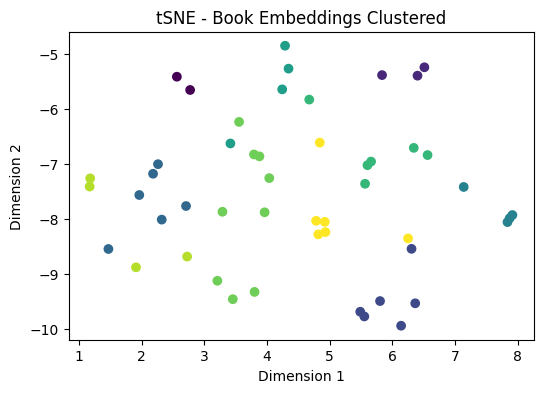

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Performing t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np.array(vectors))

# Plot the reduced data
plt.figure(figsize=(6,4))
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('tSNE - Book Embeddings Clustered')
plt.show()

Now we need to get the vectors which are closest to the cluster centroids (the center).

We want to perform embeddings only for the documents which are closest to center of each cluster.

The closest vectors will convey the summary nearer to centroid 

In [16]:
# Find the closest embeddings to the centroids

# Create an empty list that will hold your closest points
closest_indices = []

# Loop through the number of clusters
for i in range(num_clusters):
    
    # Calculates the list of Euclidean distances between each document embedding and the centroid of the current cluster
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)
    
    # Finds the index of the document with the smallest distance to the centroid, 
    # meaning it's the closest document to the center of that cluster.
    closest_index = np.argmin(distances)

    closest_indices.append(closest_index)
    
selected_indices = sorted(closest_indices)
selected_indices

[0, 3, 8, 11, 24, 28, 32, 38, 43, 49]

The documents numbers given above belongs to respective clusters

means doc#0 is closest similar to centroid of cluster 0 and may represents all documents in the clusters

and doc#3 is closest similar to centroid of cluster 1 and may represents all documents in the clusters so on..


In [17]:
selected_docs = [docs[doc] for doc in selected_indices]

In [18]:
from langchain_google_genai import ChatGoogleGenerativeAI

model=ChatGoogleGenerativeAI(model="gemini-pro",
                             temperature=0,
                             max_tokens=1000,
                             google_api_key=os.environ["GOOGLE_API_KEY"]
                            )

In [29]:
from langchain.prompts import PromptTemplate

map_prompt = """
You will be given a single passage of a book. This section will be enclosed in triple backticks (```)
Your goal is to give a summary of this section to retain the keywords and context of the passage.
Your response should be at least three paragraphs of 300 tokens each and fully encompass what was said in the passage.

```{text}```
FULL SUMMARY:
"""
map_prompt_template = PromptTemplate(template=map_prompt, 
                                     input_variables=["text"])


In [30]:
map_chain = load_summarize_chain(llm=model,
                                 chain_type="stuff",
                                 prompt=map_prompt_template)

In [33]:
# Make an empty list to hold your summaries
summary_list = []

# Loop through a range of the lenght of your selected docs
for idx, doc in enumerate(selected_docs):
    
    # Go get a summary of the chunk
    chunk_summary = map_chain.run([doc])
    
    # Append that summary to your list
    summary_list.append(chunk_summary)
    
    print (f"Summary #{idx} (chunk #{selected_indices[idx]}) - Preview: {chunk_summary[:250]} \n")

Summary #0 (chunk #0) - Preview: The passage delves into the power of the subconscious mind and its profound impact on our lives. It emphasizes the importance of cultivating a positive mindset and harnessing the infinite intelligence within us to achieve our goals and desires. The a 

Summary #1 (chunk #3) - Preview: The passage delves into the distinction between the conscious and subconscious minds, emphasizing the power of suggestion and its impact on our lives. The conscious mind, also known as the objective mind, relies on the five senses to perceive the ext 

Summary #2 (chunk #8) - Preview: The passage delves into the realm of faith healing and the power of the subconscious mind in promoting miraculous recoveries. It begins with the remarkable case of Madame Bire, a blind woman who regained her sight at the shrine of Lourdes despite hav 

Summary #3 (chunk #11) - Preview: The passage delves into the concept of mental healing and the power of the subconscious mind in facilitating

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


Summary #8 (chunk #43) - Preview: The root cause of alcoholism is negative and destructive thinking, leading to feelings of inferiority, inadequacy, defeat, frustration, and inner hostility. The solution lies in transforming these negative thoughts into positive ones through a three- 

Summary #9 (chunk #49) - Preview: The passage emphasizes the significance of maintaining a youthful mindset and spirit as we age. It begins by acknowledging the intangible yet undeniable existence of the mind, spirit, life, and virtues like goodness, truth, and beauty. The author sug 



We have our list of summaries, let's get a summary of all the summaries

In [34]:
summaries = "\n".join(summary_list)

# Convert it back to a document
summaries = Document(page_content=summaries)

print (f"The total summary has {llm.count_tokens(summaries.page_content)} tokens")

The total summary has total_tokens: 2326
 tokens


In [35]:
from langchain_google_genai import ChatGoogleGenerativeAI

summary_model=ChatGoogleGenerativeAI(model="gemini-pro",
                                     temperature=0,
                                     max_tokens=2000,
                                     google_api_key=os.environ["GOOGLE_API_KEY"]
                                    )

In [40]:
combine_prompt = """
You will be given a series of summaries from a book. The summaries will be enclosed in triple backticks (```)
Your goal is to give a verbose summary in at least 1000 tokens of what happened in the story.
The reader should be able to grasp what happened in the book.

```{text}```
VERBOSE SUMMARY:
"""
combine_prompt_template = PromptTemplate(template=combine_prompt, 
                                         input_variables=["text"])

In [41]:
reduce_chain=load_summarize_chain(llm=summary_model,
                                  chain_type="stuff",
                                  prompt=combine_prompt_template,
    #                             verbose=True # Set this to true if you want to see the inner workings
                                  )

In [42]:
output = reduce_chain.run([summaries])
print(output)

In the realm of personal development and self-improvement, the power of the subconscious mind takes center stage. This profound force within us holds the key to unlocking our true potential, shaping our experiences, and manifesting our desires. The journey begins with cultivating a positive mindset, replacing limiting beliefs with empowering ones, and aligning our thoughts with the eternal truths of life.

The subconscious mind, operating beneath the surface of our conscious awareness, is a vast reservoir of untapped potential. It accepts as true whatever the conscious mind believes, making it crucial to select thoughts and ideas that are beneficial and uplifting. Through the power of suggestion, we can reprogram our subconscious minds, overcoming fears, and creating a more positive and fulfilling reality.

Faith and belief play a pivotal role in harnessing the power of the subconscious mind. By planting the idea of healing or success in our minds and nurturing it with expectancy, we c

In [43]:
no_of_words = len(output.split())
no_of_characters = len(output)

print(f"The summary of the book has {no_of_words} words and {no_of_characters} characters")

The summary of the book has 425 words and 2849 characters


In [60]:
text_data=Document(page_content=output,
                   metadata=dict(ISBN="9781234561223",
                                 Title = "The power of your Sub-consicious mind",
                                 Author="Dr Joseph Murphy",
                                 ))

In [61]:
from langchain.vectorstores import FAISS

db = FAISS.from_documents(documents = [text_data],
                          embedding = embeddings
                         )                  
                                               

In [62]:
query = "Highlights the points author has emphasize ?"

docs = db.similarity_search(query)
print(docs[0].metadata)

{'ISBN': '9781234561223', 'Title': 'The power of your Sub-consicious mind', 'Author': 'Dr Joseph Murphy'}


### Let's try with Pinecone Client

In [63]:
os.environ["PINECONE_API_KEY"] = getpass.getpass(prompt="Enter your Pinecone API key: ")

Enter your Pinecone API key: ········


In [70]:
pinecone.init(
    api_key = os.getenv("PINECONE_API_KEY"),
    environment = "gcp-starter"
)

index_name = "gemini-pro-index"

if index_name not in pinecone.list_indexes():
    pinecone.create_index(index_name, 
                          dimension = 768, 
                          metric='cosine')
    print(f"Pinecone index: {index_name} is created")
    
index = pinecone.Index(index_name)

index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 1e-05,
 'namespaces': {'': {'vector_count': 1}},
 'total_vector_count': 1}

In [71]:
pinecone_db = Pinecone.from_documents([text_data], embeddings, index_name=index_name)

In [72]:
index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 1e-05,
 'namespaces': {'': {'vector_count': 1}},
 'total_vector_count': 1}

In [73]:
# Load the vectorstore from Pinecone Client

pinecone_vectorstore = Pinecone.from_existing_index(index_name, embeddings)

In [74]:
query = "Suggest a book on health and creative mind strategy"

response = pinecone_vectorstore.similarity_search(query)
response[0].metadata

{'Author': 'Dr Joseph Murphy',
 'ISBN': '9781234561223',
 'Title': 'The power of your Sub-consicious mind'}